# Example of DOPER - EV Fleet

### This examples demonstrates the DOPER framework for a three EV fleet with about 150 kW building base load and 100 kW Photovoltaic (PV) generation.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

### Import DOPER modules

DOPER consists of several modules which are imported here.

In [2]:
from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model
from doper.models.battery import add_battery
from doper.examples.example import parameter_add_evfleet, ts_inputs, test_default_parameter, ts_inputs_ev_schedule, parameter_add_battery
from doper.plotting import plot_dynamic

### Setup Optimization Model

DOPER passes the inputs as first arguments and parameter as second argument to the optimization model (control_model). In this example two models are loaded:
* the "base_model" with energy balance of on-site generation, e.g. Photovoltaic, and demand, e.g. building base laod
* the "add_battery" model which adds individual batteries or electric vehicles, as defined by the input parameters

An objective function is defined as the sum of energy and demand cost, eventual revenue from exporting energy, and from frequency regulation. The weighting between the objectives is again defined within the parameters of the model.

In [3]:
from pyomo.environ import Objective, minimize

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)
    model = add_battery(model, inputs, parameter)
    
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export']
              
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

### Load Example Parameter

The "parameter" dictinoary object includes all parameters of the optimization model. The high-level categories are:
* Battery: parameter of all batteries in the model. This includes number of batteries, initial and final State of Charge, power, capacity, etc.
* Controller: selection of controller options such as model timestep, optimization horizon, etc.
* Objective: weighting of the multiple objectives
* Site: specifications of the site such as timezone, import and export power limits, customer type, etc.
* Tariff: electricity tariff specified as time-of-use with any number of periods

In [4]:
parameter = test_default_parameter()

parameter = parameter_add_battery(parameter)
# parameter = parameter_add_evfleet(parameter)

print("parameter 'system' object:")
pprint(parameter['system'])
print('')

print("parameter 'batteries' object:")
pprint(parameter['batteries'])
print('')

parameter 'system' object:
{'battery': True,
 'external_gen': False,
 'genset': False,
 'hvac_control': False,
 'load_control': False,
 'pv': True,
 'reg_bidding': False,
 'reg_response': False}

parameter 'batteries' object:
[{'capacity': 200,
  'degradation_endoflife': 80,
  'degradation_replacementcost': 6000.0,
  'efficiency_charging': 0.96,
  'efficiency_discharging': 0.96,
  'maxS': 50,
  'name': 'libat01',
  'nominal_V': 400,
  'power_charge': 50,
  'power_discharge': 50,
  'self_discharging': 0.0,
  'soc_final': None,
  'soc_initial': 0.65,
  'soc_max': 1,
  'soc_min': 0.2,
  'thermal_C': 100000.0,
  'thermal_R': 0.01}]



### Load Example Data

The input data in this example is chosen to represent a medium-sized office building with rooftop photovoltaic system and three electric vehicles.

In [5]:
data = ts_inputs(parameter, load='B90', scale_load=400, scale_pv=200)
data = ts_inputs_ev_schedule(parameter, data)

c:\Users\noluc\AppData\Local\Programs\Python\Python311\Lib\site-packages\doper\examples\example.py:1362: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0, 0.3090169943749474, 0.5877852522924731, 0.8090169943749475, 0.9510565162951535, 1.0, 0.9510565162951536, 0.8090169943749475, 0.5877852522924732, 0.3090169943749475, 1.2246467991473532e-16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data.index[8:19], 'generation_pv'] = [np.sin(i/(10/(np.pi))) for i in range(11)]


### Conduct Optimization

In order to conduct the optimization, the DOPER object is initialized with the model, parameter, and the pyomo_to_pandas converter function. In the next step, the model is evaluated with the "do_optimization" class function. It takes the current inputs as input and returns a list of results.

Note that DOPER is built for application as Model Predictive Control (MPC) where the optimization model is periodically, e.g. every five minutes, updated with the most recent inputs, and reevaluated. However, in this example, do_optimization is only executed once.

In [6]:
# Define the path to the solver executable
solver_path = "C:\\Nohora\\UniValle_project\\pasto_case\\DOPER\\doper\\solvers\\Windows64\\cbc.exe"
# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization
res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res

print(standard_report(res))

Duration [s]		0.68
Objective [$]		12760.78			12760.78 (Total Cost)
Cost [$]		643.5 (Energy)	12117.27 (Demand)
CO2 Emissions [kg]		1131.09



### Result for Site

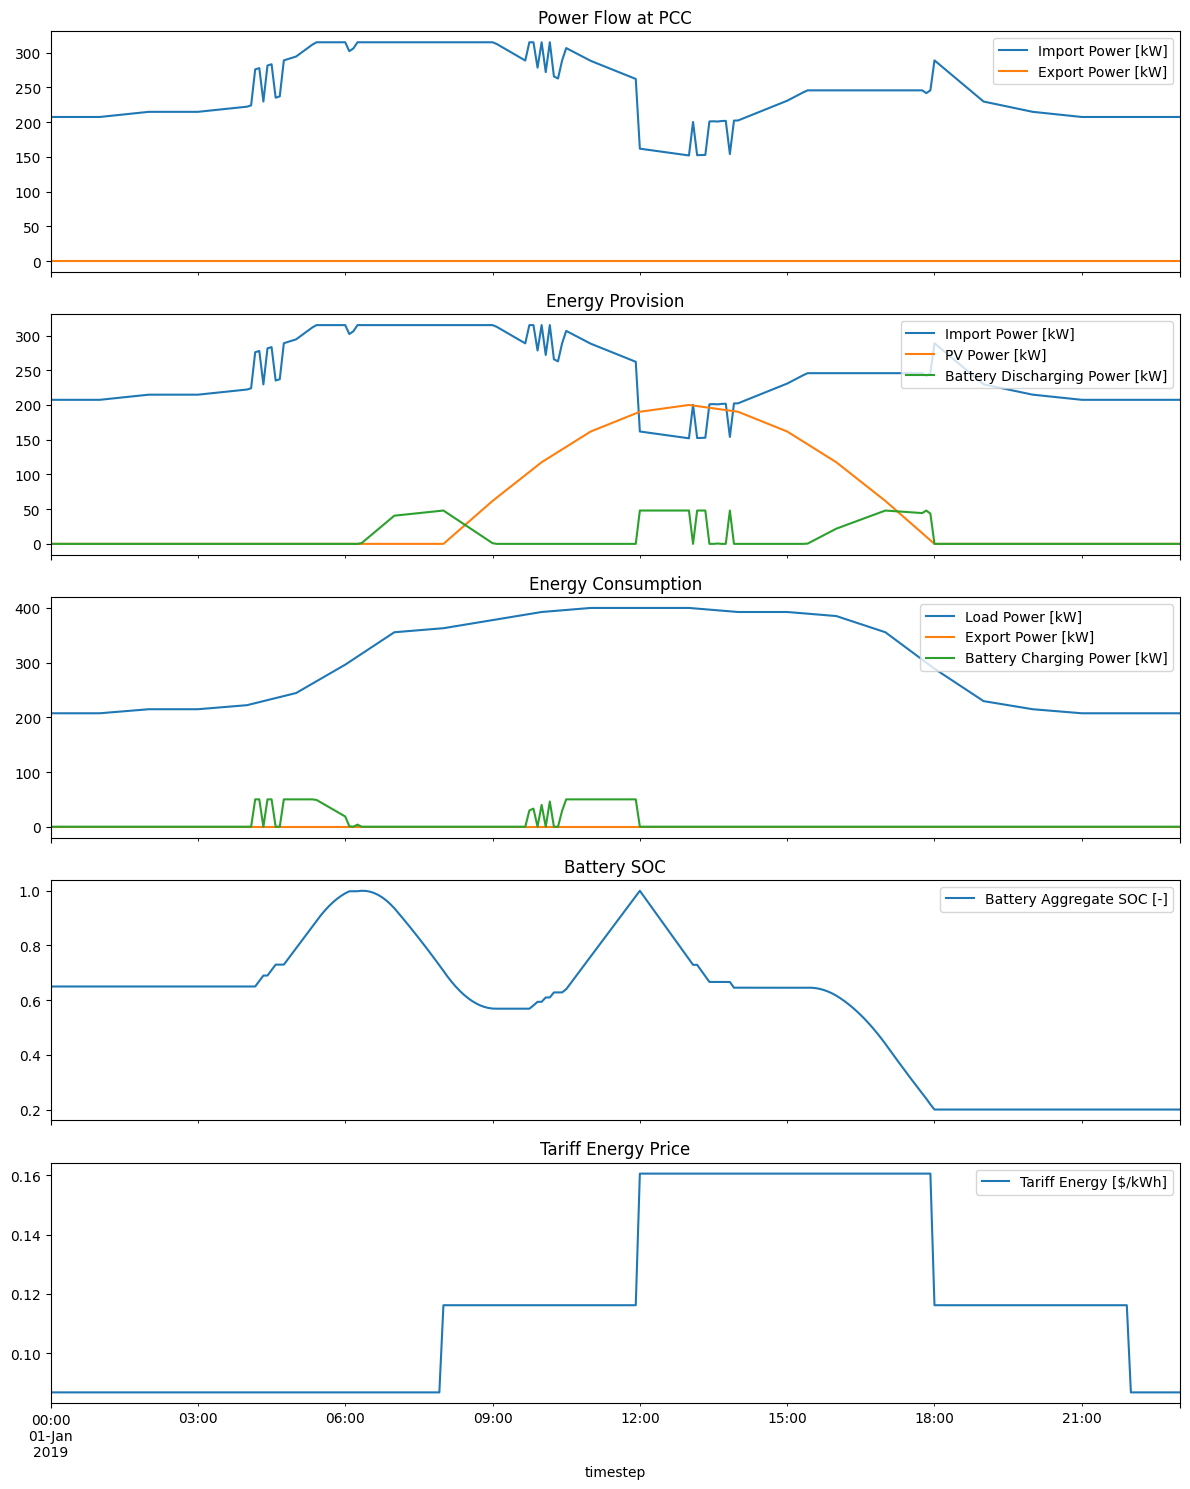

In [7]:
plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)